# Load SOAR Data (for training)
This notebook is a minimal example of how to load the RLDS SOAR data (e.g. for downstream training)

In [1]:
# redirect stderr to devnull
import contextlib
import os

devnull = open(os.devnull, 'w')
contextlib.redirect_stderr(devnull)

In [2]:

"""
1. Download a minimal SOAR dataset that's small to be used for testing

In this notebook we load a small dummy dataset for speed. If you wish to load the full dataset, 
use the download script in this directory to download the full dataset. Then it can be loaded
in the same way, changing the path to the saved dataset.
"""
import os
# use the downloading bash script, but pass in the path to the dummy dataset
SAVE_DIR = os.path.expanduser("~/dummy_soar_data")
URL_FILE = os.path.join(os.getcwd(), "test_dataset_urls.txt")

# call the bashscript
command = f"SAVE_DIR={SAVE_DIR} URL_FILE={URL_FILE} REQUIRED_SPACE_GB=0.4 bash download_dataset.sh"
print(f"Executing command: {command}")
os.system(command)

Executing command: SAVE_DIR=/home/paulzhou/dummy_soar_data URL_FILE=/home/paulzhou/research/soar/soar_data/test_dataset_urls.txt REQUIRED_SPACE_GB=0.4 bash download_dataset.sh
Saving files to /home/paulzhou/dummy_soar_data


download_dataset.sh: line 12: [: 0.4: integer expression expected
--2024-07-29 16:25:19--  https://rail.eecs.berkeley.edu/datasets/soar_release/test/features.json
Resolving rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)... 128.32.244.190
Connecting to rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8713 (8.5K) [text/plain]
Saving to: ‘/home/paulzhou/dummy_soar_data/features.json.3’

     0K ........                                              100% 68.0M=0s

2024-07-29 16:25:19 (68.0 MB/s) - ‘/home/paulzhou/dummy_soar_data/features.json.3’ saved [8713/8713]

--2024-07-29 16:25:19--  https://rail.eecs.berkeley.edu/datasets/soar_release/test/dataset_info.json
Resolving rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)... 128.32.244.190
Connecting to rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596
Saving to: ‘/

--2024-07-29 16:25:19--  https://rail.eecs.berkeley.edu/datasets/soar_release/test/soar_dataset-success.tfrecord-00000-of-00001
Resolving rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)... 128.32.244.190
Connecting to rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88012692 (84M)
Saving to: ‘/home/paulzhou/dummy_soar_data/soar_dataset-success.tfrecord-00000-of-00001.3’

     0K .......... .......... .......... .......... ..........  0% 5.92M 14s
    50K .......... .......... .......... .......... ..........  0% 25.0M 9s
   100K .......... .......... .......... .......... ..........  0% 22.2M 7s
   150K .......... .......... .......... .......... ..........  0% 21.2M 6s
   200K .......... .......... .......... .......... ..........  0% 21.1M 6s
   250K .......... .......... .......... .......... ..........  0% 15.1M 6s
   300K .......... .......... .......... .......... ..........  0% 18.7M 6s
   35

0

In [3]:
"""
2. Import the Dataloader class
"""
# install jaxrl_m if it it not already installed
# the package is located in model_training/jaxrl_m
try:
    import jaxrl_m
except ImportError:
    print("local jaxrl_m package not installed")
    jaxrl_m_path = os.path.abspath(os.path.join(os.getcwd(), "..", "model_training"))
    os.system(f"pip install -e {jaxrl_m_path}")
    
    # add the package path to sys.path
    import sys
    
    
# check that installation was successful
try:
    import jaxrl_m
except ImportError:
    print("Failed to correctly install jaxrl_m package")
    print("Please manually install the package with `pip install -e model_training`")
    exit(1)

# import dataloader class
from jaxrl_m.data.bridge_dataset import BridgeDataset

2024-07-29 16:25:22.856151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 16:25:22.856187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 16:25:22.857521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 16:25:22.864243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 16:25:23.733850: W tensorflow/compiler/tf2

In [4]:
"""
3. Load the dataset
"""
train_data = BridgeDataset(
    [SAVE_DIR],
    seed=0,
    batch_size=16,
    train=True,
)

2024-07-29 16:25:25.673795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10251 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-07-29 16:25:25.674251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10389 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-07-29 16:25:27.614538: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


Cause: Unable to locate the source code of <function _gcd_import at 0x7f1172133400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f1172133400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f1172133400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


40it [00:00, 201.48it/s]


2024-07-29 16:25:30.521391: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0c704fe600 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-29 16:25:30.521453: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1722295530.617877 2043531 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-29 16:25:30.618768: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-29 16:25:30.622038: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-29 16:25:30.622174: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-29 16:25:30.622334: E external/local_xla/xla/stream_executor/stream_executor_interna

Example batch keys: dict_keys(['observations', 'next_observations', 'actions', 'terminals'])
Actions shape: (16, 7), which is (batch_size, action_dim)
Observations shape: (16, 256, 256, 3), which is (batch_size, observation_dim)
Proprio shape: (16, 7), which is (batch_size, proprio_dim)


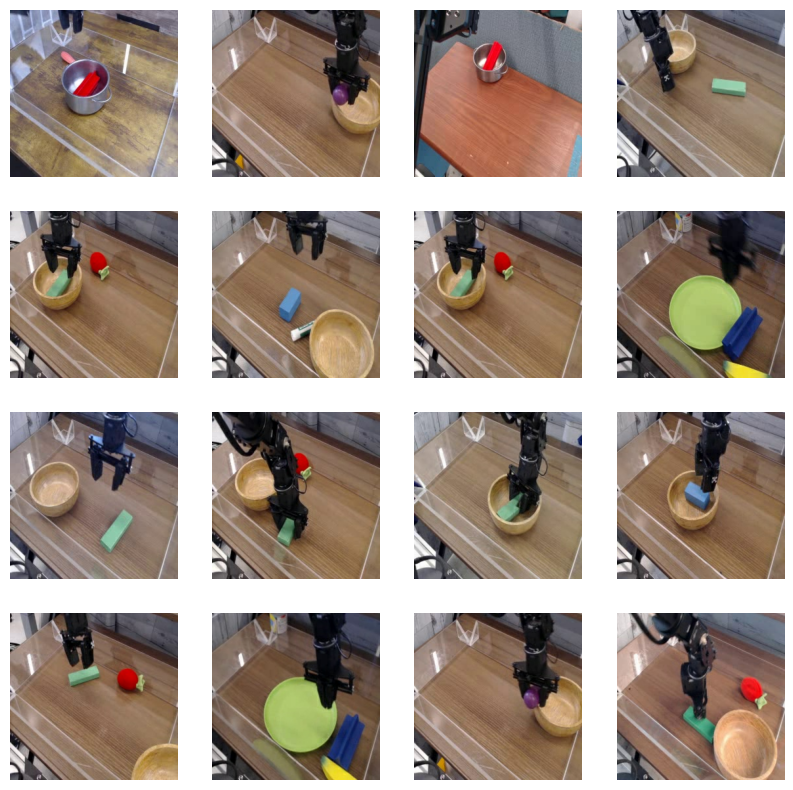

In [5]:
"""
4. Inspect an example batch
"""
import matplotlib.pyplot as plt

train_data_iter = train_data.iterator()
example_batch = next(train_data_iter)

print(f"Example batch keys: {example_batch.keys()}")
print(f"Actions shape: {example_batch['actions'].shape}, which is (batch_size, action_dim)")
print(f"Observations shape: {example_batch['observations']['image'].shape}, which is (batch_size, observation_dim)")
print(f"Proprio shape: {example_batch['observations']['proprio'].shape}, which is (batch_size, proprio_dim)")

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(example_batch['observations']['image'][i])
    plt.axis('off')
plt.show()

In [6]:
"""
5. Load only the success/failure split of the SOAR-data
If you wish, you could only load certain splits of the dataset. 
"""
success_data = BridgeDataset(
    [SAVE_DIR],
    data_splits=["success"],
    seed=0,
    batch_size=16,
    train=True,
)

failure_data = BridgeDataset(
    [SAVE_DIR],
    data_splits=["failure"],
    seed=0,
    batch_size=16,
    train=True,
)

2024-07-29 16:25:33.668336: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
40it [00:00, 1610.62it/s]
2024-07-29 16:25:34.553936: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
40it [00:00, 1087.90it/s]


## More Advanced Usage
For more advanced usage, check out the arguments of the `BridgeDataset` class at [model_training/jaxrl_m/data/bridge_dataset.py](https://github.com/rail-berkeley/soar/blob/main/model_training/jaxrl_m/data/bridge_dataset.py).

An example of how this dataset is used is in `model_training/experiments/train.py`, and the configuration and arguments of the datasets are in `model_training/experiments/configs/train_config.py` and `model_training/experiments/configs/data_config.py`.